In [26]:
import cv2
import numpy as np
import matplotlib.pylab as plt
import operator
import os
import random
import json
from multiprocessing import Process  # 多进程 
from threading import Thread  # 多线程
from utils.ImgOp import imshow
from utils.others import support_chinese
support_chinese()

(720, 1280, 3)


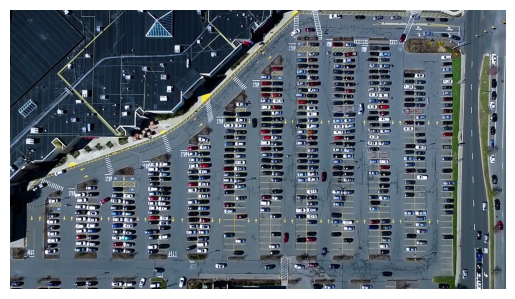

In [27]:
# 使用matplotlib显示（rgb）图像，(注意，cv2读取的图片为bgr格式)
img_bgr = cv2.imread('saveImg/scene1380.jpg')
print(img_bgr.shape)
imshow(img_bgr)
image = img_bgr.copy()

binary_filter: 1）二值过滤，将图像mask 2）转灰度图


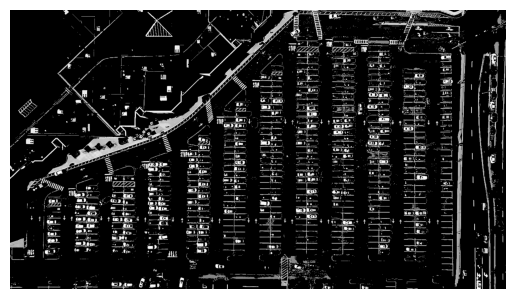

In [28]:
# 1）二值过滤，将图像mask 2）转灰度图
def binary_filter(image):
    lower = np.uint8([120, 120, 120])
    uper = np.uint8([255, 255, 255])
    binary_mask = cv2.inRange(image, lower, uper)  # 阈值二值化，lower~uper范围内为255，外为0
    mask_out = cv2.bitwise_and(image, image, mask = binary_mask)  # 利用掩膜（mask）进行“与”操作 
    binary_img = cv2.cvtColor(mask_out, cv2.COLOR_RGB2GRAY)  # 转灰度图
    print('binary_filter: 1）二值过滤，将图像mask 2）转灰度图')
    imshow(binary_img)
    return binary_img
binary_img = binary_filter(image)  # 1）二值过滤，将图像mask 2）转灰度图

edge_detection: 边缘检测,Canny边缘检测


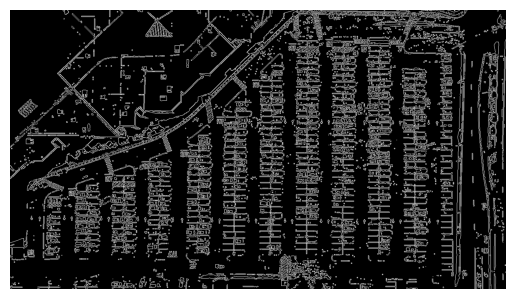

In [29]:
# 边缘检测,Canny边缘检测
def edge_detection(image):
    lower = 50
    highter = 200  # 最小阈值，最大阈值
    edge_out = cv2.Canny(image, lower, highter)
    print('edge_detection: 边缘检测,Canny边缘检测')
    imshow(edge_out)
    return edge_out
edge_out = edge_detection(binary_img)  # 边缘检测,Canny边缘检测

choose_pake: 根据图片特征人为选取车库位置,通过固定的顶点绘制区域


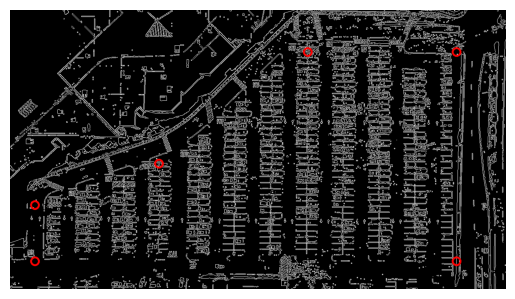

choose_pake: 绘制车库mask


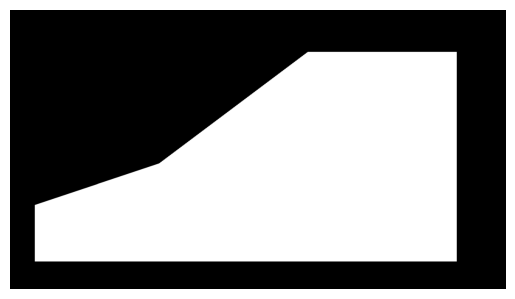

choose_pake: 绘制车库最终选取位置结果


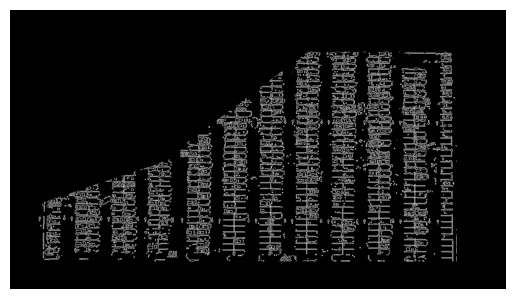

In [30]:
# 根据图片特征人为选取车库位置,通过固定的顶点绘制区域
def choose_pake(image):
    rows, cols = image.shape[:2]
    pot1 = [cols*0.05, rows*0.9]
    pot2 = [cols*0.05, rows*0.7]
    pot3 = [cols*0.3, rows*0.55]
    pot4 = [cols*0.6, rows*0.15]
    pot5 = [cols*0.9, rows*0.15]
    pot6 = [cols*0.9, rows*0.9]
    vertice = np.array([[pot1, pot2, pot3, pot4, pot5, pot6]], dtype = np.int32)
    cp_image = image.copy()
    cp_image = cv2.cvtColor(cp_image, cv2.COLOR_GRAY2BGR)  # 灰度转BGR
    for pt in vertice[0]:
        cv2.circle(cp_image, (pt[0], pt[1]), 10, (0, 0, 255), 4)  # 绘制位置,参数（图，图标大小，线粗细，颜色，图标编号）
    print('choose_pake: 根据图片特征人为选取车库位置,通过固定的顶点绘制区域')
    imshow(cp_image)

    mask = np.zeros_like(image)
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertice, 255)
        print('choose_pake: 绘制车库mask')
        imshow(mask)
    image_choose_pake = cv2.bitwise_and(image, mask)
    print('choose_pake: 绘制车库最终选取位置结果')
    imshow(image_choose_pake)
    return image_choose_pake
image_choose_pake = choose_pake(edge_out)  # 根据图片特征人为选取车库位置,通过固定的顶点绘制区域

In [31]:
# 霍夫变换，直线检测
def hoff_lines(image):
    # 输入为边缘检测后的结果
    # minLineLength线的最短长度，maxLineGap线间的最大距离（这2参数是判断直线是否符号你所需要求的）
    # rho距离精度，theta角精度，threshold检测一条直线所需最少的曲线交点（这3个参数是找直线的）
    lines = cv2.HoughLinesP(image, rho=0.1, theta=np.pi/10, threshold=15, minLineLength=9, maxLineGap=4)  # 输出所有直线信息
    return lines
lines = hoff_lines(image_choose_pake)  # 霍夫变换，直线检测

过滤后的直线个数 579
hoff_line_draw: 直线绘制


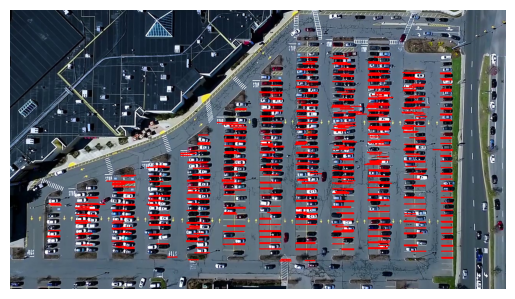

In [32]:
# 直线绘制
def draw_line(image, lines):
    draw_line_image = image.copy()
    cleaned = []  # 用于存储筛选后的直线
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(y1-y2) <= 1 and abs(x1-x2) >= 25 and abs(x2-x1) <= 55:
                cleaned.append((x1,y1,x2,y2))
                cv2.line(draw_line_image, (x1, y1), (x2, y2), [0, 0, 255], 2)
    print('过滤后的直线个数', len(cleaned))
    print('hoff_line_draw: 直线绘制')
    imshow(draw_line_image)
    return draw_line_image, cleaned
draw_line_image, cleaned_lines = draw_line(image, lines)  # 绘制直线

停车位簇数目 12
line_grouping: 将获取的直线进行分组,对分组绘制矩形


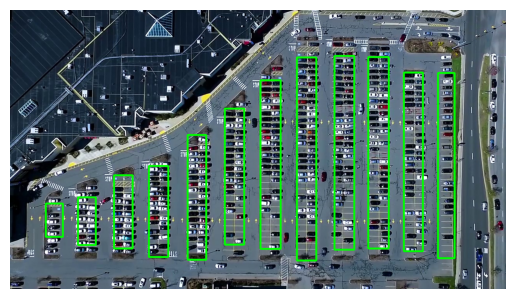

In [33]:
# 将获取的直线进行分组,对分组绘制矩形
def line_grouping(image, cleaned_lines):
    new_image = image.copy()
    list1 = sorted(cleaned_lines, key=operator.itemgetter(0, 1))  # 将直线排序,[0]位置优先
    clusters = {}  # 定义一个字典，存放每一列的簇
    dindex = 0
    clus_dist = 20  # 簇间距离阈值
    
    for i in range(len(list1)-1):
        distence = abs(list1[i+1][0] - list1[i][0])
        if distence < clus_dist:
            if not dindex in clusters.keys(): clusters[dindex] = []
            clusters[dindex].append(list1[i])
            clusters[dindex].append(list1[i+1])
        else:
            dindex += 1
    
    rects = {}
    count = 0
    for key in clusters:
        all_list = clusters[key]
        cleaned = list(set(all_list))  # 去掉重复数据
        if len(cleaned) > 5:
            cleaned = sorted(cleaned, key=lambda tup: tup[1])  # 将直线排序,[1]位置优先,tup包含一条线，即两个点(x1, y1, x2, y2)
            avg_y1 = cleaned[0][1]
            avg_y2 = cleaned[-1][1]
            avg_x1 = 0
            avg_x2 = 0
            for tup in cleaned:
                avg_x1 += tup[0]
                avg_x2 += tup[2]
            avg_x1 = avg_x1/len(cleaned)
            avg_x2 = avg_x2/len(cleaned)
            rects[count] = (avg_x1, avg_y1, avg_x2, avg_y2)
            count += 1
    print('停车位簇数目', len(rects))

    # 绘制停车位矩形
    buff = 7
    for key in rects:
        tup_topleft = (int(rects[key][0] - buff), int(rects[key][1]))
        tup_bottright = (int(rects[key][2] + buff), int(rects[key][3]))
        cv2.rectangle(new_image, tup_topleft, tup_bottright, (0, 255, 0), 3)  # 参数（图片，长方形框左上角坐标, 长方形框右下角坐标， 颜色，粗细）
    print('line_grouping: 将获取的直线进行分组,对分组绘制矩形')
    imshow(new_image)
    return new_image, rects
line_group_image, line_group = line_grouping(image, cleaned_lines)

车位数: 538
draw_seg_line: 划分出每个车位


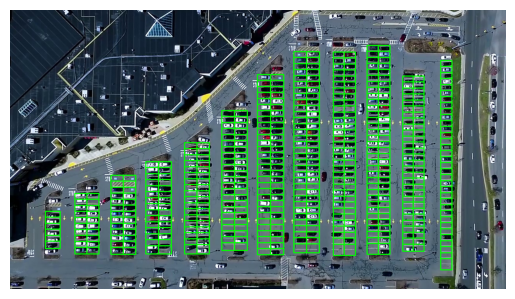

In [34]:
X = []
# 切割每一个停车位
def draw_seg_line(image, line_group):
    new_image = image.copy()
    gap = 15.5 # 车位间的距离
    stop_dict = {} # 每个车位一个字典位置
    tot_stops = 0 # 停车位总个数

    adj_y1 = {0:20, 1:-10, 2:0, 3:-11, 4:20, 5:5, 6:-15, 7:-15, 8:-10, 9:-30, 10:9, 11:-32}
    adj_y2 = {0:30, 1:23, 2:15, 3:-8, 4:-15, 5:15, 6:15, 7:-20, 8:15, 9:15, 10:0, 11:30}
    adj_x1 = {0:-8, 1:-15, 2:-15, 3:-15, 4:-15, 5:-15, 6:-15, 7:-15, 8:-10, 9:-10, 10:-10, 11:0}
    adj_x2 = {0:0, 1:15, 2:15, 3:15, 4:15, 5:15, 6:15, 7:15, 8:10, 9:10, 10:10, 11:0}
    # 微调
    for key in line_group:
        tup = line_group[key]
        x1 = int(tup[0] + adj_x1[key])
        x2 = int(tup[2] + adj_x2[key])
        y1 = int(tup[1] + adj_y1[key])
        y2 = int(tup[3] + adj_y2[key])
        cv2.rectangle(new_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        num_split = int(abs(y2-y1)//gap)
        for i in range(0, num_split):
            y = int(y1 + gap*i)
            cv2.line(new_image, (x1, y), (x2, y), (0, 255, 0), 2)
        
        # 统计车位数
        if key > 0 and key < len(line_group)-1:  # 除第一簇和最后一簇，其余簇车位为两列
            x = int((x1 + x2)/2)
            cv2.line(new_image, (x, y1), (x, y2), (0, 255, 0), 2)
        if key == 0 or key == (len(line_group)-1):
            tot_stops += num_split + 1
        else:
            tot_stops += 2*(num_split + 1)
        
        # 车位与字典逐一对应
        if key == 0 or key == (len(line_group)-1):
            for i in range(0, num_split+1):
                cur_len = len(stop_dict)
                y = int(y1 + gap*i)
                if(key == 0):
                    stop_dict[(x1, y+gap, x2, y, 1)] = cur_len + 1  
                else: 
                    stop_dict[(x1, y+gap, x2, y, 0)] = cur_len + 1  
        else:
            for i in range(0, num_split+1):
                cur_len = len(stop_dict)
                y = int(y1 + gap*i)
                x = int((x1 + x2)/2)
                stop_dict[(x1, y+gap, x, y, 0)] = cur_len + 1
                stop_dict[(x, y+gap, x2, y, 1)] = cur_len + 2
    print('车位数:', tot_stops)
    print('draw_seg_line: 划分出每个车位')
    imshow(new_image)
    cv2.imwrite('seg_line_image.jpg', new_image)
    return new_image, stop_dict
seg_line_image, stop_dict = draw_seg_line(image, line_group)  # 切割每一个停车位

In [35]:
stop_dict

{(91, 534.5, 129, 519, 1): 1,
 (91, 549.5, 129, 534, 1): 2,
 (91, 565.5, 129, 550, 1): 3,
 (91, 580.5, 129, 565, 1): 4,
 (91, 596.5, 129, 581, 1): 5,
 (91, 611.5, 129, 596, 1): 6,
 (91, 627.5, 129, 612, 1): 7,
 (167, 488.5, 198, 473, 0): 8,
 (198, 488.5, 229, 473, 1): 9,
 (167, 503.5, 198, 488, 0): 10,
 (198, 503.5, 229, 488, 1): 11,
 (167, 519.5, 198, 504, 0): 12,
 (198, 519.5, 229, 504, 1): 13,
 (167, 534.5, 198, 519, 0): 14,
 (198, 534.5, 229, 519, 1): 15,
 (167, 550.5, 198, 535, 0): 16,
 (198, 550.5, 229, 535, 1): 17,
 (167, 565.5, 198, 550, 0): 18,
 (198, 565.5, 229, 550, 1): 19,
 (167, 581.5, 198, 566, 0): 20,
 (198, 581.5, 229, 566, 1): 21,
 (167, 596.5, 198, 581, 0): 22,
 (198, 596.5, 229, 581, 1): 23,
 (167, 612.5, 198, 597, 0): 24,
 (198, 612.5, 229, 597, 1): 25,
 (167, 627.5, 198, 612, 0): 26,
 (198, 627.5, 229, 612, 1): 27,
 (167, 643.5, 198, 628, 0): 28,
 (198, 643.5, 229, 628, 1): 29,
 (260, 441.5, 292, 426, 0): 30,
 (292, 441.5, 324, 426, 1): 31,
 (260, 456.5, 292, 441, 

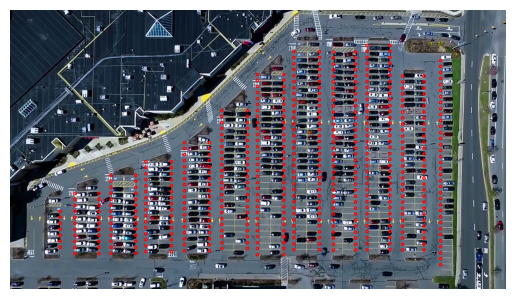

In [36]:
gap = 15.5
total= []
img = img_bgr.copy()

for x1, y1, x2, y2, key in stop_dict.keys():
    x = 0
    y = 0

    if key == 1:
        x = x2
        y = int(y2)
        cv2.circle(img, (x2, int(y2)), 3, (0, 0, 255), 2)  
    else:
        x = x1
        y = int(y1 - gap)
        cv2.circle(img, (x1, int(y1 - gap)), 3, (0, 0, 255), 2)  
    total.append({"x": x, "y": y, "is_entrance": 0, "is_empty": 1, "id" : None, 
                "is_parking": 1})
    # 绘制位置,参数（图，图标大小，线粗细，颜色，图标编号）
imshow(img)

In [37]:
# 添加到文件
with open('./config/settings.json', 'r') as f:
    data = json.load(f)
with open('./config/data_lot.json', 'w') as f:
    data['cnt'] += len(total)
    json.dump(total, f, indent=4)
with open('./config/settings.json', 'w') as f:
    json.dump(data, f, indent=4)